# **Proyek Machine Learning dengan Time Series**

*   **Nama:** Venessa Yumadila Syahra
*   **ID Dicoding:** nessasyahra

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = pd.read_csv('google stocks.csv')
data.tail()

,Date,Open,High,Low,Close,Volume,Name
3014,2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
3015,2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
3016,2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL
3017,2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,GOOGL
3018,2017-12-29,1055.49,1058.05,1052.70,1053.40,1180340,GOOGL


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

In [4]:
data.head()

,Date,Open,High,Low,Close,Volume,Name,Year
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL,2006
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL,2006
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL,2006
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL,2006
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL,2006


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
 7   Year    3019 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 188.8+ KB


In [6]:
data = data.drop(columns=['Date', 'Name'])
data.head()

,Open,High,Low,Close,Volume,Year
0,211.47,218.05,209.32,217.83,13137450,2006
1,222.17,224.70,220.09,222.84,15292353,2006
2,223.22,226.00,220.97,225.85,10815661,2006
3,228.66,235.49,226.85,233.06,17759521,2006
4,233.44,236.94,230.70,233.68,12795837,2006


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)
data_new = scaler.transform(data)
data_new = pd.DataFrame(data_new, columns=data.columns)
data_new.head()

,Open,High,Low,Close,Volume,Year
0,-0.917259,-0.900246,-0.914534,-0.889591,3.155248,-1.593657
1,-0.871974,-0.872243,-0.868682,-0.868390,3.864542,-1.593657
2,-0.867530,-0.866768,-0.864936,-0.855652,2.391023,-1.593657
3,-0.844507,-0.826806,-0.839902,-0.825140,4.676619,-1.593657
4,-0.824277,-0.820700,-0.823511,-0.822516,3.042805,-1.593657


In [8]:
close = data_new['Close'].values
year = data_new['Year'].values

<Axes: >

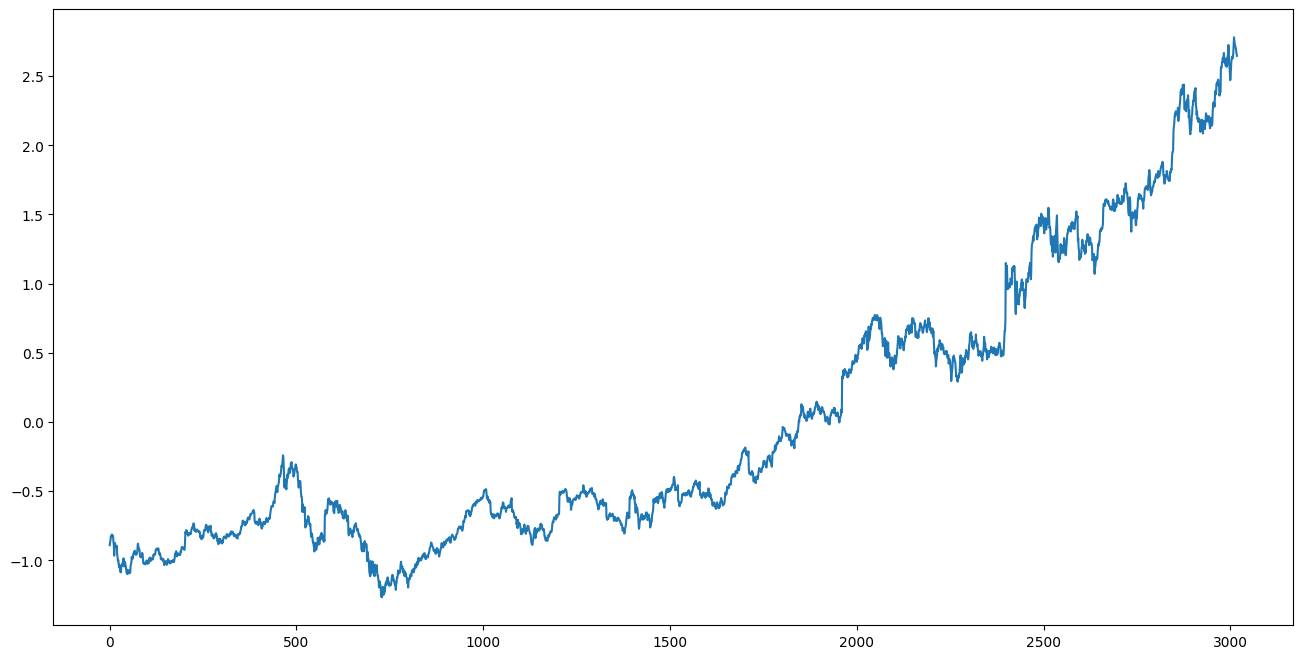

In [9]:
data_new['Close'].plot(figsize=(16,8))

In [10]:
from sklearn.model_selection import train_test_split

x_test, x_train, y_test, y_train = train_test_split(close, year, test_size=0.2, shuffle=False)

In [11]:
print('X train: ', len(x_train))
print('X test: ', len(x_test))
print('Y train: ', len(y_train))
print('Y test: ', len(y_test))

X train:  604
X test:  2415
Y train:  604
Y test:  2415


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:1], w[:-1]))
  return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(x_train, window_size=60,
                             batch_size=100, shuffle_buffer=1000)

In [18]:
val_set = windowed_dataset(x_test, window_size=60,
                           batch_size=100, shuffle_buffer=1000)

In [17]:
class ThresholdedMAECallback(tf.keras.callbacks.Callback):
    def __init__(self , threshold):
        super(ThresholdedMAECallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_mae = logs.get('mae')
        if current_mae < self.threshold:
            print(f"\nMAE kurang dari ({self.threshold}) training berhenti")
            self.model.stop_training = True

threshold_mae = (data_new['Close'].max() - data_new['Close'].min()) * 10/100
print(f'Threshold MAE sebesar {threshold_mae}')
callback_mae = ThresholdedMAECallback(threshold_mae)

Threshold MAE sebesar 0.40466501864086346


In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1,
                           padding='causal', activation='relu', input_shape=[None,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 50)                1650      
                                                                 
 dense_1 (Dense)             (None, 30)                1

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [22]:
hist = model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[callback_mae])

Epoch 1/100
6/6 [==============================] - 8s 321ms/step - loss: 1.1766 - mae: 1.6765 - val_loss: 0.2356 - val_mae: 0.6354
Epoch 2/100
6/6 [==============================] - 1s 136ms/step - loss: 1.1737 - mae: 1.6736 - val_loss: 0.2376 - val_mae: 0.6379
Epoch 3/100
6/6 [==============================] - 1s 96ms/step - loss: 1.1678 - mae: 1.6677 - val_loss: 0.2410 - val_mae: 0.6422
Epoch 4/100
6/6 [==============================] - 1s 99ms/step - loss: 1.1575 - mae: 1.6574 - val_loss: 0.2463 - val_mae: 0.6489
Epoch 5/100
6/6 [==============================] - 1s 136ms/step - loss: 1.1444 - mae: 1.6442 - val_loss: 0.2529 - val_mae: 0.6570
Epoch 6/100
6/6 [==============================] - 1s 135ms/step - loss: 1.1296 - mae: 1.6294 - val_loss: 0.2602 - val_mae: 0.6661
Epoch 7/100
6/6 [==============================] - 1s 134ms/step - loss: 1.1138 - mae: 1.6136 - val_loss: 0.2679 - val_mae: 0.6757
Epoch 8/100
6/6 [==============================] - 1s 136ms/step - loss: 1.0976 - mae

###Plot

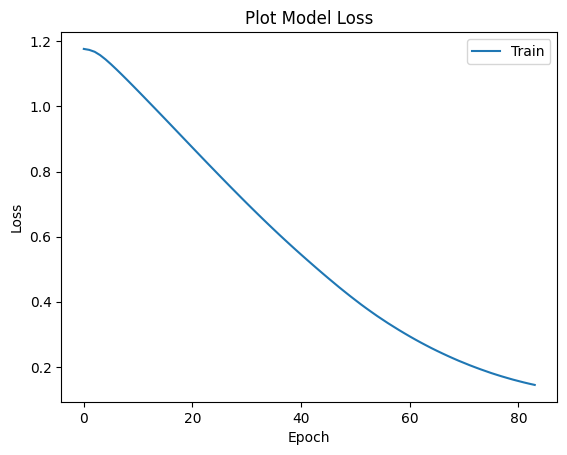

In [23]:
plt.plot(hist.history['loss'])
plt.title('Plot Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()